# Speed Dating Analysis

The aim of this project was to get the best match accuracy of a participant in a speed dating event. We want to be able to predict the likeliness that a participant will find a match by using learning models on the data set. The data set is veru unclean so a lot of preprocessing was necessary in order to achieve the highest accuracy possible in the models used.

## Analyzing the Data

After loading the data, we will perform a little analysis to get a feel of the data set and to prove that some features in the data set are more strongly correlate to the target feature which is the *match rate*.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, tree, metrics

In [2]:
# Read CSV Speed Dating Data using Pandas.
data = pd.read_csv('../Speed Dating Data.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


As you can see there is a warning message above that tells us some columns have mixed types, we will fix this later on in the preprocessing step.

In [3]:
# Count rows of data.
print(data.count())

iid             8378
id              8377
gender          8378
idg             8378
condtn          8378
wave            8378
round           8378
position        8378
positin1        6532
order           8378
partner         8378
pid             8368
match           8378
int_corr        8220
samerace        8378
age_o           8274
race_o          8305
pf_o_att        8289
pf_o_sin        8289
pf_o_int        8289
pf_o_fun        8280
pf_o_amb        8271
pf_o_sha        8249
dec_o           8378
attr_o          8166
sinc_o          8091
intel_o         8072
fun_o           8018
amb_o           7656
shar_o          7302
                ... 
shar1_3         3974
attr7_3         2016
sinc7_3         2016
intel7_3        2016
fun7_3          2016
amb7_3          2016
shar7_3         2016
attr4_3         2959
sinc4_3         2959
intel4_3        2959
fun4_3          2959
amb4_3          2959
shar4_3         2959
attr2_3         2959
sinc2_3         2959
intel2_3        2959
fun2_3       

Some columns are completely filled up. A filled up column should have *8378* rows. However some have as low as *2016* which is no good. It is pretty clear that columns with a large number of empty values most likely hinder rather than help our prediction models. 

In [4]:
# Display the mean age.
print("Mean Age:", data["age"].mean())

# Display match rate based on the age of the participant and their gender.
match_rate_gender = data.groupby(['age', 'gender']).mean()
print(match_rate_gender['match'])

Mean Age: 26.3589279247
age   gender
18.0  1         0.000000
19.0  0         0.500000
      1         0.000000
20.0  0         0.366667
      1         0.120000
21.0  0         0.191257
      1         0.277778
22.0  0         0.156593
      1         0.127148
23.0  0         0.149901
      1         0.175711
24.0  0         0.136564
      1         0.149144
25.0  0         0.239560
      1         0.227749
26.0  0         0.168699
      1         0.167109
27.0  0         0.156463
      1         0.160194
28.0  0         0.155063
      1         0.188372
29.0  0         0.162996
      1         0.154696
30.0  0         0.123223
      1         0.157025
31.0  0         0.240741
      1         0.070423
32.0  0         0.087719
      1         0.104575
33.0  0         0.128000
      1         0.111111
34.0  0         0.144578
      1         0.115942
35.0  0         0.166667
36.0  0         0.120000
      1         0.050000
37.0  1         0.000000
38.0  0         0.105263
39.0  1      

I wanted to prove that some features are closely correlated to the match rate. It is pretty well established that gender and age most likely play a role in how succesful they are. The mean age is 26, so I assume that the youngest of women under 26 probably have a higher match rate than the youngest of men under 26. The data seems to show this, however I also displayed the data in a graph.

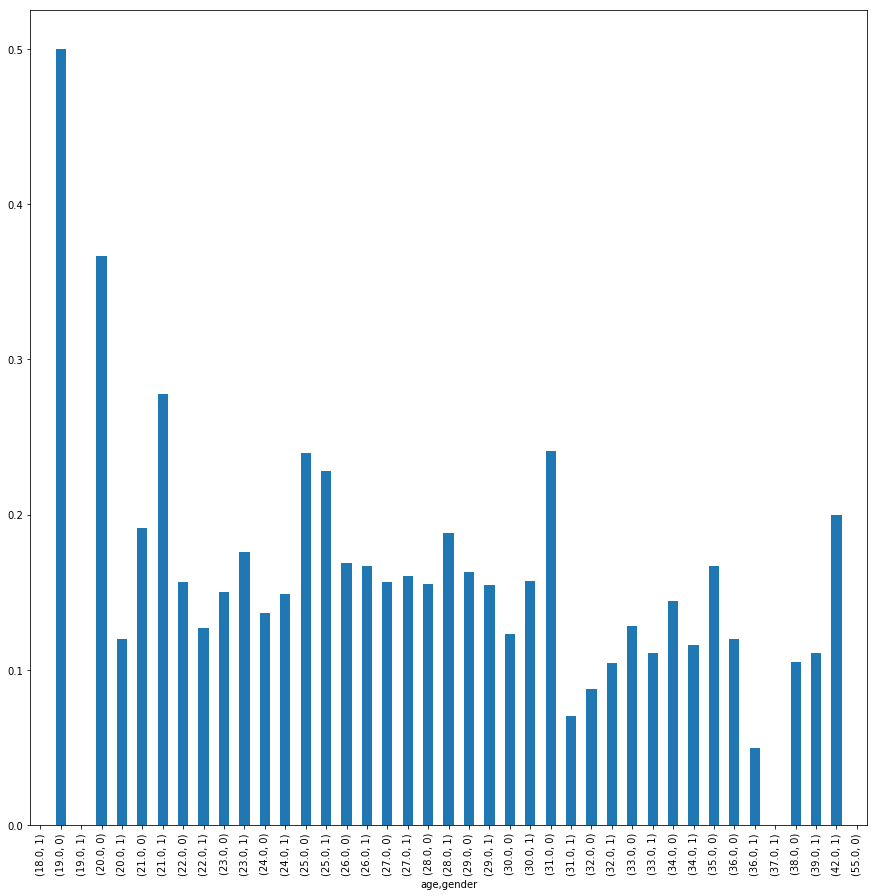

In [5]:
# Plot match rate based on age of particpant and their gender.
plt.figure(figsize=(15, 15))
match_rate_gender['match'].plot.bar()
plt.show()

It does seem to be true that for girls under 21 the match rate is much higher than for men. After that things start to level off. I took this a step further and added the age of their partner from the speed dating event.

In [6]:
# Display the match rate when age of participant, age of partner, and gender are considered.
match_rate_age = data.groupby(['age', 'gender', 'age_o']).mean()
print(match_rate_age['match'])

age   gender  age_o
18.0  1       19.0     0.000000
              20.0     0.000000
              21.0     0.000000
19.0  0       18.0     0.000000
              19.0     0.000000
              20.0     1.000000
              21.0     1.000000
              22.0     0.250000
      1       19.0     0.000000
              20.0     0.000000
              21.0     0.000000
20.0  0       18.0     0.000000
              19.0     0.000000
              20.0     0.333333
              21.0     0.833333
              22.0     0.333333
      1       19.0     1.000000
              20.0     0.333333
              21.0     0.000000
              24.0     0.000000
              25.0     0.250000
              26.0     0.000000
              27.0     0.000000
              29.0     0.000000
              30.0     0.000000
              34.0     0.000000
21.0  0       18.0     0.000000
              19.0     0.000000
              20.0     0.000000
              21.0     0.461538
                    

In the output above, we can see that young women tend to prefer older men. For example, at the age of 19, if a woman's partner is 20, 21, or 22, the match rate is much higher than for men. In fact, for 19 year old men, the match rate is 0. This match rate seems to hold true for the years below the age of 26.

The point of all this is to prove that some features are strongly correlated to the match rate. However, the opposite is true as well, that some features are also redundant, but we will show this using a clustering algorithm later on. The clustering algorithm will tell us which are the most strongly correlated, and which are the most redundant.

## Preprocessing

Here we clean up the data before passing it to our learning models.

Normally, before preprocessing the data, we create a copy of the original data, which I did in python scripts but I will skip that for now. First, since we saw earlier that many columns had a significant amount of empty values, I'm going to create a threshold where I remove all columns where more than 23% of their data are empty. Moreover, there are a couple of features we can already drop right off the bat. The *field* column can be dropped because there is already a *field_cd* column that holds the columns numerical encoding.

In [7]:
print(data.shape)

# Drop any columns if 23% or more of its values are NaN.
data = data.dropna(thresh=len(data)*0.77, axis=1)

# Convert columns to 1-dimensional Series array
series = data.columns.to_series()

# Drop columns to make dataset smaller and more manageable.
data = data.drop(series["field"], axis=1)

print(data.shape)

(8378, 196)
(8378, 111)


The column *sports* contains a couple of string values when it should represent a rating system from 1 to 10. Because there are only a few string values, we will replace them with the mean value of the column.

In [8]:
# Convert all values in column to string type if not already.
# This will allow us to perform string operations on non-numeric values.
data['sports'] = data['sports'].astype(str)

# Convert column to all caps so all the data will have the same format.
data['sports'] = data['sports'].str.upper()

# Remove all spaces between strings in each column.
data['sports'] = data['sports'].str.replace(" ", "")

# Convert string values to NaN if the string contains any keywords.
searchfor = ['TEACH']
data.loc[data['sports'].str.contains('|'.join(searchfor), na=False), 'sports'] = np.NaN

# Convert the column back to floating point format.
data['sports'] = data['sports'].astype(float)

# Replace the NaN values that we added with the mean of the column.
data['sports'] = data['sports'].fillna(data['sports'].mean())

There are two columns, *career* and *career_c*. The *career* column contains string values that represent a participant's aspiring career. The *career_c* column represents the numeric encoding of the *career* column, which makes the *career* column redundant. However, the column holding the encoding is missing some encodings for certain rows, so we will need to do the encoding ourselves for the missing rows.

In [9]:
# If column 'career_c' is empty in places where column 'career' is not,
# use column 'career' as the filler value.
data['career_c'] = data['career_c'].fillna(data['career'])
    
# Convert columns to 1-dimensional Series array
series = data.columns.to_series()

# Drop the 'career' column after it is used as a filler for column 'career_c'.
data = data.drop(series["career"], axis=1)

# Convert all values in column to string type if not already.
# This will allow us to perform string operations on non-numeric values.
data['career_c'] = data['career_c'].astype(str)

# Convert column to all caps so all the data will have the same format.
data['career_c'] = data['career_c'].str.upper()

# Remove all spaces between strings in each column.
data['career_c'] = data['career_c'].str.replace(" ", "")

# Convert string values to an integer equivalent if the string contains any keywords.
searchfor = ['LAW']
data.loc[data['career_c'].str.contains('|'.join(searchfor), na=False), 'career_c'] = 1

searchfor = ['RESEARCH']
data.loc[data['career_c'].str.contains('|'.join(searchfor), na=False), 'career_c'] = 2

searchfor = ['ECON']
data.loc[data['career_c'].str.contains('|'.join(searchfor), na=False), 'career_c'] = 7

searchfor = ['HUMAN']
data.loc[data['career_c'].str.contains('|'.join(searchfor), na=False), 'career_c'] = 9

searchfor = ['TECH']
data.loc[data['career_c'].str.contains('|'.join(searchfor), na=False), 'career_c'] = 15

# Convert values back to floating point type.
# Now there should be no more string values in column 'career_c'.
data['career_c'] = data['career_c'].astype(float)
    
print(data['career_c'])

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
10       1.0
11       1.0
12       1.0
13       1.0
14       1.0
15       1.0
16       1.0
17       1.0
18       1.0
19       1.0
20       7.0
21       7.0
22       7.0
23       7.0
24       7.0
25       7.0
26       7.0
27       7.0
28       7.0
29       7.0
        ... 
8348     7.0
8349     7.0
8350     7.0
8351     7.0
8352     7.0
8353     7.0
8354     7.0
8355     7.0
8356    15.0
8357    15.0
8358    15.0
8359    15.0
8360    15.0
8361    15.0
8362    15.0
8363    15.0
8364    15.0
8365    15.0
8366    15.0
8367    15.0
8368    15.0
8369    15.0
8370    15.0
8371    15.0
8372    15.0
8373    15.0
8374    15.0
8375    15.0
8376    15.0
8377    15.0
Name: career_c, Length: 8378, dtype: float64


The next column that needs preprocessing is the *from* column. This is a column of string values which is a problem because it needs to be encoded. Luckily many of the strings are repeating so we will create a function that makes the strings as homogenous as possible and then encodes them using *scikit learn's* Label Encoder.

This is what the data looks like before encoding it.

In [10]:
print(data['from'])

0                 Chicago
1                 Chicago
2                 Chicago
3                 Chicago
4                 Chicago
5                 Chicago
6                 Chicago
7                 Chicago
8                 Chicago
9                 Chicago
10                Alabama
11                Alabama
12                Alabama
13                Alabama
14                Alabama
15                Alabama
16                Alabama
17                Alabama
18                Alabama
19                Alabama
20            Connecticut
21            Connecticut
22            Connecticut
23            Connecticut
24            Connecticut
25            Connecticut
26            Connecticut
27            Connecticut
28            Connecticut
29            Connecticut
              ...        
8348    London & New York
8349    London & New York
8350    London & New York
8351    London & New York
8352    London & New York
8353    London & New York
8354    London & New York
8355    Lond

This is what the data looks like after encoding it.

In [11]:
def encode_data(target, data):

    # Label Encoder.
    le = LabelEncoder()

    # Convert column to all caps so all the data will have the same format.
    data[target] = data[target].str.upper()

    # Remove all spaces between strings in each column.
    data[target] = data[target].str.replace(" ", "")

    # All string values are encoded to an integer.
    data[target] = le.fit_transform(data[target])

    return data

In [12]:
# Change all NaN values to an integer.
data[data['from'].isnull()] = 0

# All non-strings are converted to string type.
data['from'] = data['from'].astype(str)
    
# Run the Label Encoder algorithm,
# this will encode all strings to an integer.
data = encode_data("from", data)

print(data['from'])

0        48
1        48
2        48
3        48
4        48
5        48
6        48
7        48
8        48
9        48
10        2
11        2
12        2
13        2
14        2
15        2
16        2
17        2
18        2
19        2
20       57
21       57
22       57
23       57
24       57
25       57
26       57
27       57
28       57
29       57
       ... 
8348    106
8349    106
8350    106
8351    106
8352    106
8353    106
8354    106
8355    106
8356     71
8357     71
8358     71
8359     71
8360     71
8361     71
8362     71
8363     71
8364     71
8365     71
8366     71
8367     71
8368     71
8369     71
8370     71
8371     71
8372     71
8373     71
8374     71
8375     71
8376     71
8377     71
Name: from, Length: 8378, dtype: int64


We will do the same with the *zipcode* column. We will use the Label Encoder to encode the column of zipcodes since many are also repeating. Moreover, since this is the last preprocessing step, we will replace all remaining empty values with the mean values of their respective columns. This is better than simple dropping any row that contains any empty values because by doing so, a significant amount of data is removed. I tried this and I removed more than half the rows from the original data set.

In [13]:
# Change all NaN values to an integer.
data[data['zipcode'].isnull()] = 0
    
# All non-strings are converted to string type.
data['zipcode'] = data['zipcode'].astype(str)
    
# Run the Label Encoder algorithm,
# this will encode all strings to an integer.
data = encode_data("zipcode", data)

# All remaining NaN values are converted 
# to the mean of their respective column.
data = data.fillna(data.mean())

print(data['zipcode'])

0       252
1       252
2       252
3       252
4       252
5       252
6       252
7       252
8       252
9       252
10      197
11      197
12      197
13      197
14      197
15      197
16      197
17      197
18      197
19      197
20      256
21      256
22      256
23      256
24      256
25      256
26      256
27      256
28      256
29      256
       ... 
8348     74
8349     74
8350     74
8351     74
8352     74
8353     74
8354     74
8355     74
8356    313
8357    313
8358    313
8359    313
8360    313
8361    313
8362    313
8363    313
8364    313
8365    313
8366    313
8367    313
8368    313
8369    313
8370    313
8371    313
8372    313
8373    313
8374    313
8375    313
8376    313
8377    313
Name: zipcode, Length: 8378, dtype: int64


## Preprocessing Redundant Features with Clustering Techniques

The next step is to use Recursive Feature Elimination to remove redundant features that hinder the accuracy rate of our models.

I used the RFE with a Logistic Regression model. The Logistic Regression assigns weights to every feature, then the recursion cuts out some features with the largest weights and then trains again. In my case this repeats until it is left with 3 features which have the highest weights and lowest cost. In essence, the RFE will tell you which 3 features are most important, but it will also give weights to every other feature in the dataset that tells you how correlated each feature is to the target column.

In [14]:
# Target column.
target = "match"

# Drop the target label, which we save separately.
X = data.drop([target], axis=1).values
y = data[target].values

# Estimator for Recursive Feature Elimination (RFE).
model = LogisticRegression()
    
# RFE will use Logistic Regression.
# The Result will be a unique set of values which represents
# the column's weight of importance within the dataset.
rfe = RFE(model, 3)
fit = rfe.fit(X, y)

print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

3
[False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False  True False False False False False False False False False False
 False]
[ 42  50  11  51   2  41  20  87  86 106  72  71  23  15  69  61 103  79
  92 105  65  89   1  33  91  43  56  59  96  76  44  93  95  48   7  22
  21 104 107  52  10 101  58  66  32  34  24  31  30  90  39  37  54  35
  36  94  64  78  25  73  57  84  85  98  77  99  81  55  49  60 102  29
  19  68  82  67  88  80  62   5  13  26 

As is visible, a weight is assigned to every feature. Three of them are assigned the number 1. These three represent the data that is most correlated to the *match* column.

In [15]:
header_list = list(data.columns.values)

# Any column with a weight of 88 or over will be removed.
# We will consider anything above a weight of 88 as redundant.
ix = 0
for rank in fit.ranking_:
    if rank >= 88:
        print(header_list[ix])
    ix += 1

order
race_o
pf_o_sin
pf_o_int
pf_o_amb
attr_o
amb_o
prob_o
met_o
imprelig
from
date
art
theater
sinc1_1
fun1_1
intel4_1
intel2_1
numdat_2
amb1_2


I decided to make the weight threshold 88. So anything greater than or equal to 88 is considered redundant and can be removed. The output above displays which features can be removed.

We can implement a simple Decision Tree to show what are accuracy rate is like so far.

In [16]:
def decision_tree(target, data):

    # Drop the target label, which we save separately.
    X = data.drop([target], axis=1).values
    y = data[target].values

    # Split data in a 20/80 split.
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    # Initialize a decison tree with a max_depth of 10.
    clf_tree = tree.DecisionTreeClassifier(max_depth=10)

    # Fit the model with the training data.
    clf_tree.fit(X_train, y_train)

    # Use the test data to calculate the score.
    print("Decision Tree Score (No Cross-validation):", clf_tree.score(X_test, y_test))
    
decision_tree("match", data)

Decision Tree Score (No Cross-validation): 1.0


The score give us 100% accuracy. This is because one of the columns is acting as a predictor. The column doing this is the *dec* column. I removed it and ran the Decision Tree again.

In [17]:
# Remove predictor column.
data = data.drop(series["dec"], axis=1)

decision_tree("match", data)

Decision Tree Score (No Cross-validation): 0.90214797136


Now we will remove the columns deemed as redundant by our RFE model.

In [18]:
data = data.drop(series["iid"], axis=1)
data = data.drop(series["attr4_1":"amb4_1"], axis=1)
data = data.drop(series["gender"], axis=1)
data = data.drop(series["order"], axis=1)
data = data.drop(series["fun_o"], axis=1)
data = data.drop(series["shar_o"], axis=1)
data = data.drop(series["imprelig"], axis=1)
data = data.drop(series["prob"], axis=1)
data = data.drop(series["match_es"], axis=1)
data = data.drop(series["satis_2"], axis=1)
data = data.drop(series["amb1_2"], axis=1)
data = data.drop(series["fun3_2"], axis=1)
data = data.drop(series["positin1"], axis=1)
data = data.drop(series["sinc1_2"], axis=1)

decision_tree("match", data)

Decision Tree Score (No Cross-validation): 0.909307875895


The accuracy rating improved. In the next step, we will implement some more models to train on the preprocessed data set.